In [1]:
import torch
from torch.utils.data import Dataset, DataLoader
import os, os.path 
import numpy 
import pickle
from glob import glob
import torch.nn as nn
import torch.nn.functional as F
import pandas as pd
from scipy import signal
from sklearn.metrics import mean_squared_error
import seaborn as sns 
import matplotlib.pyplot as plt
"""
    number of trajectories in each city
    # austin --  train: 43041 test: 6325 
    # miami -- train: 55029 test:7971
    # pittsburgh -- train: 43544 test: 6361
    # dearborn -- train: 24465 test: 3671
    # washington-dc -- train: 25744 test: 3829
    # palo-alto -- train:  11993 test:1686

    trajectories sampled at 10HZ rate, input 5 seconds, output 6 seconds
    
"""

'\n    number of trajectories in each city\n    # austin --  train: 43041 test: 6325 \n    # miami -- train: 55029 test:7971\n    # pittsburgh -- train: 43544 test: 6361\n    # dearborn -- train: 24465 test: 3671\n    # washington-dc -- train: 25744 test: 3829\n    # palo-alto -- train:  11993 test:1686\n\n    trajectories sampled at 10HZ rate, input 5 seconds, output 6 seconds\n    \n'

In [2]:
device = 'cuda'

## Create a Torch.Dataset class for the training dataset

In [3]:
from glob import glob
import pickle5
import numpy as np

ROOT_PATH = "C:/Users/Administrator/cse151b-spring2022/argo2/"

cities = ["austin", "miami", "pittsburgh", "dearborn", "washington-dc", "palo-alto"]
splits = ["train", "test"]

def get_city_trajectories(city="palo-alto", split="train", normalized=False):
    f_in = ROOT_PATH + split + "/" + city + "_inputs"
    inputs = pickle5.load(open(f_in, "rb"))
    inputs = np.asarray(inputs)
    
    resampled = []
    for i in inputs:
        resampled.append(signal.resample(i, 60))
        

    resampled = np.array(resampled)
    resampled =resampled / 20000
    #print(resampled.shape)
    outputs = None
    
    if split=="train":
        f_out = ROOT_PATH + split + "/" + city + "_outputs"
        outputs = pickle5.load(open(f_out, "rb"))
        outputs = np.asarray(outputs)
        outputs = outputs / 20000

        return torch.from_numpy(resampled).float(), torch.from_numpy(outputs).float()

    if split=="test":
    
        return torch.from_numpy(resampled).float(), torch.from_numpy(np.array([]))

def transform(tup):
    transed = (signal.resample(tup[0], 60), tup[1])
    return transed / 20000

    

class ArgoverseDataset(Dataset):
    """Dataset class for Argoverse"""
    def __init__(self, city: str, split:str, transform=None, device='cpu'):
        super(ArgoverseDataset, self).__init__()
        self.transform = transform
        self.split = split
        self.inputs, self.outputs = get_city_trajectories(city=city, split=split, normalized=False)
        self.inputs = self.inputs.to(device)
        self.outputs = self.outputs.to(device)
    def __len__(self):
        return len(self.inputs)

    def __getitem__(self, idx):

        if self.split == 'train':
            data = (self.inputs[idx], self.outputs[idx])
        if self.split == 'test':
            data = self.inputs[idx]
            
        if self.transform:
            #data[0] = self.transform(data[0])
            data = self.transform(data)

        return data

# intialize a dataset
city = 'palo-alto' 
split = 'train'
train_dataset  = ArgoverseDataset(city = city, split = split, device=device)

## Create a DataLoader class for training

In [4]:
batch_sz = 256  # batch size 
train_loader = DataLoader(train_dataset,batch_size=batch_sz)

In [5]:
test_dataset = ArgoverseDataset(city=city, split='test', device=device)
test_loader = DataLoader(test_dataset,batch_size=batch_sz)

# LSTM

In [6]:
epochs = 50
hidden_size = 16
lr = 0.01

In [7]:
class EncoderRNN(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, dropout_p=0.1):
        super(EncoderRNN, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers

        self.dropout = nn.Dropout(dropout_p)
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers = self.num_layers, batch_first=True)

    def forward(self, input):
        #h0 = torch.zeros(1, input.size(0), self.hidden_size).float().to(device)
        #c0 = torch.zeros(1, input.size(0), self.hidden_size).float().to(device)
        input = self.dropout(input)
        out, hid = self.lstm(input)
        return out, hid

    # def initHidden(self):
    #     return torch.zeros(1, 1, self.hidden_size, device=device)


In [8]:
class DecoderRNN(nn.Module):
    def __init__(self, hidden_size, output_size, num_layers, dropout_p=0.1):
        super(DecoderRNN, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers

        
        self.lstm = nn.LSTM(hidden_size, hidden_size, num_layers=self.num_layers, batch_first=True)
        # self.attn = nn.Linear(self.hidden_size*2, 60)
        # self.attn_combine = nn.Linear(self.hidden_size*2, self.hidden_size)
        # self.dropout = nn.Dropout(self.dropout_p)
        self.out = nn.Linear(hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)

        

    def forward(self, input, hidden):
        
        output, hidden = self.lstm(input, hidden)
        output = self.out(output)
        #output = self.softmax(output)
        return output, hidden

    # def init_state(self, encoded):
    #     #torch.zeros(1, 1, self.hidden_size, device=device)
    #     return encoded[1]


In [9]:
# encoder = EncoderRNN(input_size=2, hidden_size=hidden_size, num_layers=2)
# decoder = DecoderRNN(hidden_size=hidden_size, output_size=2, num_layers=2)
# encoder.to(device)
# decoder.to(device)
# optimizer = torch.optim.Adam(encoder.parameters(), lr=lr)

In [27]:
def train(train_set):
    encoder = EncoderRNN(input_size=2, hidden_size=hidden_size, num_layers=2)
    decoder = DecoderRNN(hidden_size=hidden_size, output_size=2, num_layers=2)
    encoder.to(device)
    decoder.to(device)
    optimizer = torch.optim.Adam(encoder.parameters(), lr=lr)

    criterion = nn.MSELoss()
    losses = []
    for epoch in range(epochs):
        for x, y in train_set:
            #print(f'input x shape: {x.shape}')
            #print(f'input y shape: {y.shape}')
            encoder.train()
            optimizer.zero_grad()
            encoded, hid = encoder(x)
            #print(f'encoded shape: {encoded.shape}')
            outputs, hid = decoder(encoded, hid)
            
            #print(f'decoded shape: {outputs.shape}')
            train_loss = criterion(outputs, y)
            #print(outputs)
            train_loss.backward()
            optimizer.step()

        losses.append(float(train_loss.item()))    
        if epoch % 10 == 0:
            print(f'epoch {epoch}, loss: {train_loss.item()}')

    return encoder, decoder, losses

In [11]:
#sns.lineplot(y = losses, x = range(epochs))
#plt.savefig

In [28]:
def test_predictions(test_set, enc, dec, city):
    preds = torch.tensor([])
    for x in test_set:
        enc.eval()
        dec.eval()

        encoded, hid = enc(x)
        outputs, hid = dec(encoded, hid)
        outputs = outputs.to('cpu').detach()
        outputs = outputs * 20000
        preds = torch.cat((preds, outputs), dim=0)
        #preds.append(outputs)    

    preds_2 = []
    for i in preds:
        preds_2.append(i.flatten())

    df = pd.DataFrame(preds_2)
    for col in df.columns:
        df[col] = df[col].apply(lambda x: x.item())
    df.columns = ['v' + str(i) for i in (range(120))]
    df['ID'] = [str(i) + '_' + city for i in (range(len(test_set.dataset)))]

    return df

epoch 0, loss: 0.005131986457854509
epoch 10, loss: 0.0032755788415670395
epoch 20, loss: 0.002467469545081258
epoch 30, loss: 0.0023509596940129995
epoch 40, loss: 0.0022356777917593718


c:\ProgramData\Anaconda3\envs\data_analysis\lib\site-packages\ipykernel_launcher.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`


<function matplotlib.pyplot.savefig(*args, **kwargs)>

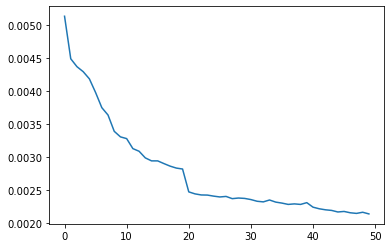

In [29]:
batch_sz = 256  # batch size 
train_dataset = ArgoverseDataset(city = 'palo-alto', split = 'train', device=device)
train_loader_palo = DataLoader(train_dataset,batch_size=batch_sz)

test_dataset = ArgoverseDataset(city='palo-alto', split='test', device=device)
test_loader_palo = DataLoader(test_dataset,batch_size=batch_sz)


enc, dec, losses = train(train_loader_palo)
out_palo = test_predictions(test_loader_palo, enc, dec, 'palo-alto')

sns.lineplot(y = losses, x = range(epochs))
plt.savefig


In [14]:
train_dataset = ArgoverseDataset(city = 'austin', split = 'train', device=device)
train_loader_austin = DataLoader(train_dataset,batch_size=batch_sz)

test_dataset = ArgoverseDataset(city='austin', split='test', device=device)
test_loader_austin = DataLoader(test_dataset,batch_size=batch_sz)


enc, dec, losses = train(train_loader_austin)
out_austin = test_predictions(test_loader_austin, enc, dec, 'austin')

epoch 0, loss: 0.009244410321116447
epoch 10, loss: 0.008229849860072136
epoch 20, loss: 0.008089055307209492
epoch 30, loss: 0.00805894285440445
epoch 40, loss: 0.00805406179279089


c:\ProgramData\Anaconda3\envs\data_analysis\lib\site-packages\ipykernel_launcher.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`


In [15]:
train_dataset = ArgoverseDataset(city = 'miami', split = 'train', device=device)
train_loader_miami = DataLoader(train_dataset,batch_size=batch_sz)

test_dataset = ArgoverseDataset(city='miami', split='test', device=device)
test_loader_miami = DataLoader(test_dataset,batch_size=batch_sz)


enc, dec, losses = train(train_loader_miami)
out_miami = test_predictions(test_loader_miami, enc, dec, 'miami')

epoch 0, loss: 0.025771314278244972
epoch 10, loss: 0.02177749015390873
epoch 20, loss: 0.021472187712788582
epoch 30, loss: 0.02138374373316765
epoch 40, loss: 0.021365245804190636


c:\ProgramData\Anaconda3\envs\data_analysis\lib\site-packages\ipykernel_launcher.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`


In [16]:
train_dataset = ArgoverseDataset(city = 'pittsburgh', split = 'train', device=device)
train_loader_pittsburgh = DataLoader(train_dataset,batch_size=batch_sz)

test_dataset = ArgoverseDataset(city='pittsburgh', split='test', device=device)
test_loader_pittsburgh = DataLoader(test_dataset,batch_size=batch_sz)


enc, dec, losses = train(train_loader_pittsburgh)
out_pittsburgh = test_predictions(test_loader_pittsburgh, enc, dec, 'pittsburgh')

epoch 0, loss: 0.010783861391246319
epoch 10, loss: 0.008646922186017036
epoch 20, loss: 0.00860297679901123
epoch 30, loss: 0.008568313904106617
epoch 40, loss: 0.008547035977244377


c:\ProgramData\Anaconda3\envs\data_analysis\lib\site-packages\ipykernel_launcher.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`


In [17]:
train_dataset = ArgoverseDataset(city = 'dearborn', split = 'train', device=device)
train_loader_dearborn = DataLoader(train_dataset,batch_size=batch_sz)

test_dataset = ArgoverseDataset(city='dearborn', split='test', device=device)
test_loader_dearborn = DataLoader(test_dataset,batch_size=batch_sz)


enc, dec, losses = train(train_loader_dearborn)
out_dearborn = test_predictions(test_loader_dearborn, enc, dec, 'dearborn')

epoch 0, loss: 0.06876182556152344
epoch 10, loss: 0.06412059813737869
epoch 20, loss: 0.06400150060653687
epoch 30, loss: 0.0638786181807518
epoch 40, loss: 0.06377626210451126


c:\ProgramData\Anaconda3\envs\data_analysis\lib\site-packages\ipykernel_launcher.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`


In [18]:
train_dataset = ArgoverseDataset(city = 'washington-dc', split = 'train', device=device)
train_loader_washington = DataLoader(train_dataset,batch_size=batch_sz)

test_dataset = ArgoverseDataset(city='washington-dc', split='test', device=device)
test_loader_washington = DataLoader(test_dataset,batch_size=batch_sz)


enc, dec, losses = train(train_loader_washington)
out_washington = test_predictions(test_loader_washington, enc, dec, 'washington-dc')

epoch 0, loss: 0.016487132757902145
epoch 10, loss: 0.015472347848117352
epoch 20, loss: 0.014981640502810478
epoch 30, loss: 0.014875959604978561
epoch 40, loss: 0.014822814613580704


c:\ProgramData\Anaconda3\envs\data_analysis\lib\site-packages\ipykernel_launcher.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`


In [25]:
0.016487132757902145 * 20000

329.7426551580429

In [19]:
"""
    number of trajectories in each city
    # austin --  train: 43041 test: 6325 
    # miami -- train: 55029 test:7971
    # pittsburgh -- train: 43544 test: 6361
    # dearborn -- train: 24465 test: 3671
    # washington-dc -- train: 25744 test: 3829
    # palo-alto -- train:  11993 test:1686

    trajectories sampled at 10HZ rate, input 5 seconds, output 6 seconds
    
"""

'\n    number of trajectories in each city\n    # austin --  train: 43041 test: 6325 \n    # miami -- train: 55029 test:7971\n    # pittsburgh -- train: 43544 test: 6361\n    # dearborn -- train: 24465 test: 3671\n    # washington-dc -- train: 25744 test: 3829\n    # palo-alto -- train:  11993 test:1686\n\n    trajectories sampled at 10HZ rate, input 5 seconds, output 6 seconds\n    \n'

In [20]:
seq_result = pd.concat([out_austin, out_miami, out_pittsburgh, out_dearborn, out_washington, out_palo], axis=0)

In [21]:
out_miami

,v0,v1,v2,v3,v4,v5,v6,v7,v8,v9,...,v111,v112,v113,v114,v115,v116,v117,v118,v119,ID
0,4594.164551,593.487000,4679.035156,1782.869751,4877.182129,2227.464111,5370.826172,2503.581543,5798.839355,2191.306152,...,291.375366,-1037.450439,288.512695,-1038.822876,286.387360,-1039.795288,282.346741,-1042.425171,278.503601,0_miami
1,-10182.574219,544.582031,-9606.491211,-135.450958,-8731.247070,-1338.176392,-8840.571289,-1108.741699,-8771.163086,-1316.220215,...,-1405.163696,-3402.020264,-1405.565186,-3401.718506,-1405.109741,-3401.263916,-1404.697266,-3400.469971,-1405.264404,1_miami
2,5339.036621,298.234222,5670.623047,214.221634,6023.845703,78.025017,6343.198242,323.120361,6343.576172,213.181381,...,78.633278,-1038.499634,66.356064,-1053.744385,53.246914,-1070.161133,44.140369,-1089.761719,43.972881,2_miami
3,4924.218262,713.216980,5079.324219,2283.355957,5272.743652,2813.492188,5519.493164,3089.389893,5635.434570,2845.612793,...,386.003113,-1066.353027,383.734711,-1067.662109,380.435577,-1068.895752,376.662476,-1071.426025,372.982910,3_miami
4,5555.431152,327.582794,5774.207031,183.565918,6067.661133,14.508665,6345.577637,232.783112,6302.487793,78.270432,...,60.653984,-1044.104736,48.031063,-1061.461426,35.421848,-1080.860474,30.604601,-1103.999268,37.299393,4_miami
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7966,-1276.857544,2326.123779,14.248789,3107.310059,111.985504,3394.500000,133.314438,3921.260010,152.211487,3706.751221,...,2080.305908,-1244.254395,2038.868164,-1243.413696,1998.714233,-1245.107300,1960.082642,-1248.420166,1926.810181,7966_miami
7967,4391.926758,694.929688,4882.635254,1141.881470,5431.858887,1092.413940,5995.572754,1228.148682,6303.464355,1037.812988,...,173.261169,-1023.401917,167.358521,-1028.353149,160.466583,-1036.512695,154.450394,-1046.212158,147.629822,7967_miami
7968,-1806.880127,1131.236816,317.827454,1474.795288,675.820129,1521.112305,389.345001,1917.597046,19.851028,2221.679199,...,1631.986328,-1125.244385,1631.703735,-1128.062012,1630.967529,-1131.401978,1629.306641,-1135.251709,1626.793701,7968_miami
7969,-1187.430908,2978.611572,-101.979675,3946.589111,68.599579,4147.581543,172.599548,4529.883789,237.789154,4110.792480,...,2486.291748,-1393.583374,2431.482178,-1343.754883,2362.679932,-1302.115112,2281.249268,-1274.386108,2191.514893,7969_miami


In [22]:
seq_result.to_csv('seq_result.csv', index=False)

In [23]:
seq_result

,v0,v1,v2,v3,v4,v5,v6,v7,v8,v9,...,v111,v112,v113,v114,v115,v116,v117,v118,v119,ID
0,962.567932,-693.372498,-49.638153,-801.457153,112.891197,-709.244629,258.044312,-671.463013,96.557739,-761.679382,...,1308.728027,-591.067078,1307.620239,-602.068909,1303.947876,-620.871460,1304.786499,-650.387085,1314.858765,0_austin
1,319.805450,141.750580,-244.078934,-155.169373,-140.587692,-428.437592,-229.159897,-320.734680,-414.009247,-272.971680,...,1293.444580,-635.186707,1288.675781,-642.735229,1283.478882,-654.868469,1287.385132,-671.549316,1313.055786,1_austin
2,1159.914673,-71.822998,99.772217,-395.863647,129.435059,-549.387939,140.644318,-576.463928,-57.491364,-597.404541,...,1324.049072,-552.522400,1324.143677,-561.729797,1319.239380,-578.835632,1319.523438,-605.876892,1322.520508,2_austin
3,-80.409050,1463.862915,52.217545,1940.990112,-329.069794,2025.319580,-461.468689,2100.540771,-62.703194,2194.368896,...,1952.025635,-138.920547,1951.281006,-139.925476,1949.994263,-141.849823,1949.605469,-143.099426,1948.032715,3_austin
4,2054.545654,-734.349182,1226.631714,-967.156860,1156.185913,-934.666687,1118.501099,-783.604370,1341.803101,-658.240601,...,1393.031616,-424.461670,1392.602905,-428.318237,1397.749146,-438.104126,1417.502563,-457.325439,1439.801514,4_austin
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1681,-1247.900391,-455.744263,-1212.770630,-173.395569,-1267.413818,-294.179321,-1553.954224,-318.581177,-1505.412720,-518.760986,...,370.255402,-50.322712,377.707184,-53.932964,385.394409,-57.831406,392.847351,-61.276852,400.207947,1681_palo-alto
1682,147.834427,-573.721558,267.254120,-320.408630,385.596741,-178.161270,500.868866,-220.734482,352.692291,-406.737640,...,198.004837,247.138443,204.924942,244.644440,212.825531,243.543381,220.286255,242.031662,227.014420,1682_palo-alto
1683,-1423.583374,2060.592285,-1573.127563,1980.399780,-1279.949829,2206.351318,-1506.974976,2273.049561,-1504.950806,2139.585205,...,2333.726562,-422.979309,2337.493652,-423.184631,2341.053467,-423.539581,2344.164062,-423.715698,2348.487305,1683_palo-alto
1684,1138.744629,1111.202393,934.236328,1273.613525,823.001831,1326.743530,740.325134,1431.362061,775.268250,1495.653564,...,1276.496704,1082.242432,1272.352905,1081.021973,1266.977539,1079.172485,1260.531860,1077.735962,1255.046143,1684_palo-alto


## Sample a batch of data and visualize 

In [24]:
# import matplotlib.pyplot as plt
# import random


# def show_sample_batch(sample_batch):
#     """visualize the trajectory for a batch of samples"""
#     inp, out = sample_batch
#     batch_sz = inp.size(0)
#     agent_sz = inp.size(1)
    
#     fig, axs = plt.subplots(1,batch_sz, figsize=(15, 3), facecolor='w', edgecolor='k')
#     fig.subplots_adjust(hspace = .5, wspace=.001)
#     axs = axs.ravel()   
#     for i in range(batch_sz):
#         axs[i].xaxis.set_ticks([])
#         axs[i].yaxis.set_ticks([])
        
#         # first two feature dimensions are (x,y) positions
#         axs[i].scatter(inp[i,:,0], inp[i,:,1])
#         axs[i].scatter(out[i,:,0], out[i,:,1])

        
# for i_batch, sample_batch in enumerate(train_loader):
#     inp, out = sample_batch
#     """
#     TODO:
#       implement your Deep learning model
#       implement training routine
#     """
#     show_sample_batch(sample_batch)
#     break